In [1]:
############## IMPORTING ALL LIBRARIES ######################
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
from Preprocess import NepaliPreprocess
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *
from tensorflow.keras.models import  Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
## LOADING THE PRETRAINED WORD2VEC model : 
model_W2V = Word2Vec.load("./Pretrained_wordEmbeddings/nepaliW2V_5Million.model")
model_W2V.wv.most_similar('मनोरन्जन')

[('मनोरञ्जन', 0.8099161982536316),
 ('मजा', 0.6251221895217896),
 ('मज्जा', 0.6017283797264099),
 ('मनोरंजन', 0.5746675729751587),
 ('आनन्द', 0.5526579022407532),
 ('आम्तसन्तुष्टि', 0.5368422865867615),
 ('विश्राम', 0.5320387482643127),
 ('सन्न्यास', 0.519502580165863),
 ('भरपुर', 0.5134987831115723),
 ('मनोरञ्जनात्मक', 0.49824845790863037)]

In [3]:
w2v_weights = model_W2V.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print(vocab_size, embedding_size)

456030 200


In [4]:
# CONVERT WORD INTO TOKEN
def word2token(word):
    try:
        return model_W2V.wv.key_to_index[word]

    except KeyError:

        return 0
        
# COVERT TOKEN INTO WORD
def token2word(token):
    return model_W2V.wv.index_to_key[token]


In [5]:
data = pd.read_csv('./Data/Data.csv')

data = data.replace({'label' : { 'entertainment' : 'मनोरन्जन', 'sports' : 'खेलकुद', 'business' : 'व्यापार' }})


data = data.drop(['paras'], axis= 1 )

data.head()

,headings,label
0,कर्णालीका सुइना,मनोरन्जन
1,साकुराजस्तो प्रेमकथा,मनोरन्जन
2,भद्रगोल नै ट्रेन्डिङमा,मनोरन्जन
3,फेरिए लोकभाका चर्चामा सामाजिक गीत,मनोरन्जन
4,भूकम्पले भत्केको सपना,मनोरन्जन


In [36]:
data['Length of News'] = data['headings'].apply(lambda s :len(s.split()))

In [37]:

fig = px.histogram(data, x="Length of News")
fig.show()

In [8]:
data.len.quantile(0.9)

45.0

In [9]:


count_df = data[['label','headings']].groupby('label').aggregate({'headings':'count'}).reset_index().sort_values('headings',ascending=False)
count_df.head()

,label,headings
2,व्यापार,2628
0,खेलकुद,2574
1,मनोरन्जन,2268


In [10]:
px.bar(count_df,x='label',y='headings',
 labels = {"label": "Category of News", "headings": "Total headings in each class"},
  color = "label", color_continuous_scale = "darkmint")

In [11]:
"""
Applies all the required preprocessing before converting into tokens
It applies : 
1 -> Regex Cleaning to get only the Nepali Words 
2 -> Removes any stopwords if present like अघि अझै किन किनभने
3 -> Performs Stemming
"""
Data_cleaner = NepaliPreprocess()
data["headings"] = data["headings"].apply(lambda x: Data_cleaner.Reg_and_Stemming(x))


In [12]:
data = data.drop(["len"], axis= 1)
data.head()

,headings,label
0,कर्णाली सुइना,मनोरन्जन
1,साकुराजस्तो प्रेमकथा,मनोरन्जन
2,भद्रगोल ट्रेन्डिङ,मनोरन्जन
3,फेरिए लोकभा चर्चा सामाजिक गीत,मनोरन्जन
4,भूकम्प भत्क सपना,मनोरन्जन


In [13]:
MAX_SEQUENCE_LENGTH = 20
class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset
        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.label, return_counts=True)
        self.seq_length = seq_length
        
    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            
 
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])
                                
            yield (words, cat)

In [14]:
sequences = SequenceIterator(data, seq_length= 30)

In [15]:
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}
print(cat_dict)

{'खेलकुद': 0, 'मनोरन्जन': 1, 'व्यापार': 2}


In [16]:
############## PADDING THE TOKENS RETURNED FROM THE SequenceIterator Class############
set_x = []
set_y = []
############## CONVERTING THE NP ARRAY TO LIST TO APPLY TOKENIZATION #################
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)


In [17]:

VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))


categories, ccount = np.unique(train_y, return_counts=True)
n_categories = len(categories)

Train Shapes - X: (6350, 20) - Y: (6350,)
Val Shapes - X: (1120, 20) - Y: (1120,)


In [18]:

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [19]:
training = model.fit(train_x, train_y, epochs=5, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/5
100/100 [==============================] - 12s 54ms/step - loss: 0.2849 - accuracy: 0.9036 - val_loss: 0.1906 - val_accuracy: 0.9223
Epoch 2/5
100/100 [==============================] - 3s 30ms/step - loss: 0.1430 - accuracy: 0.9570 - val_loss: 0.1706 - val_accuracy: 0.9312
Epoch 3/5
100/100 [==============================] - 3s 28ms/step - loss: 0.0955 - accuracy: 0.9739 - val_loss: 0.1711 - val_accuracy: 0.9330
Epoch 4/5
100/100 [==============================] - 3s 26ms/step - loss: 0.0664 - accuracy: 0.9819 - val_loss: 0.1633 - val_accuracy: 0.9384
Epoch 5/5
100/100 [==============================] - 3s 29ms/step - loss: 0.0455 - accuracy: 0.9899 - val_loss: 0.1821 - val_accuracy: 0.9366


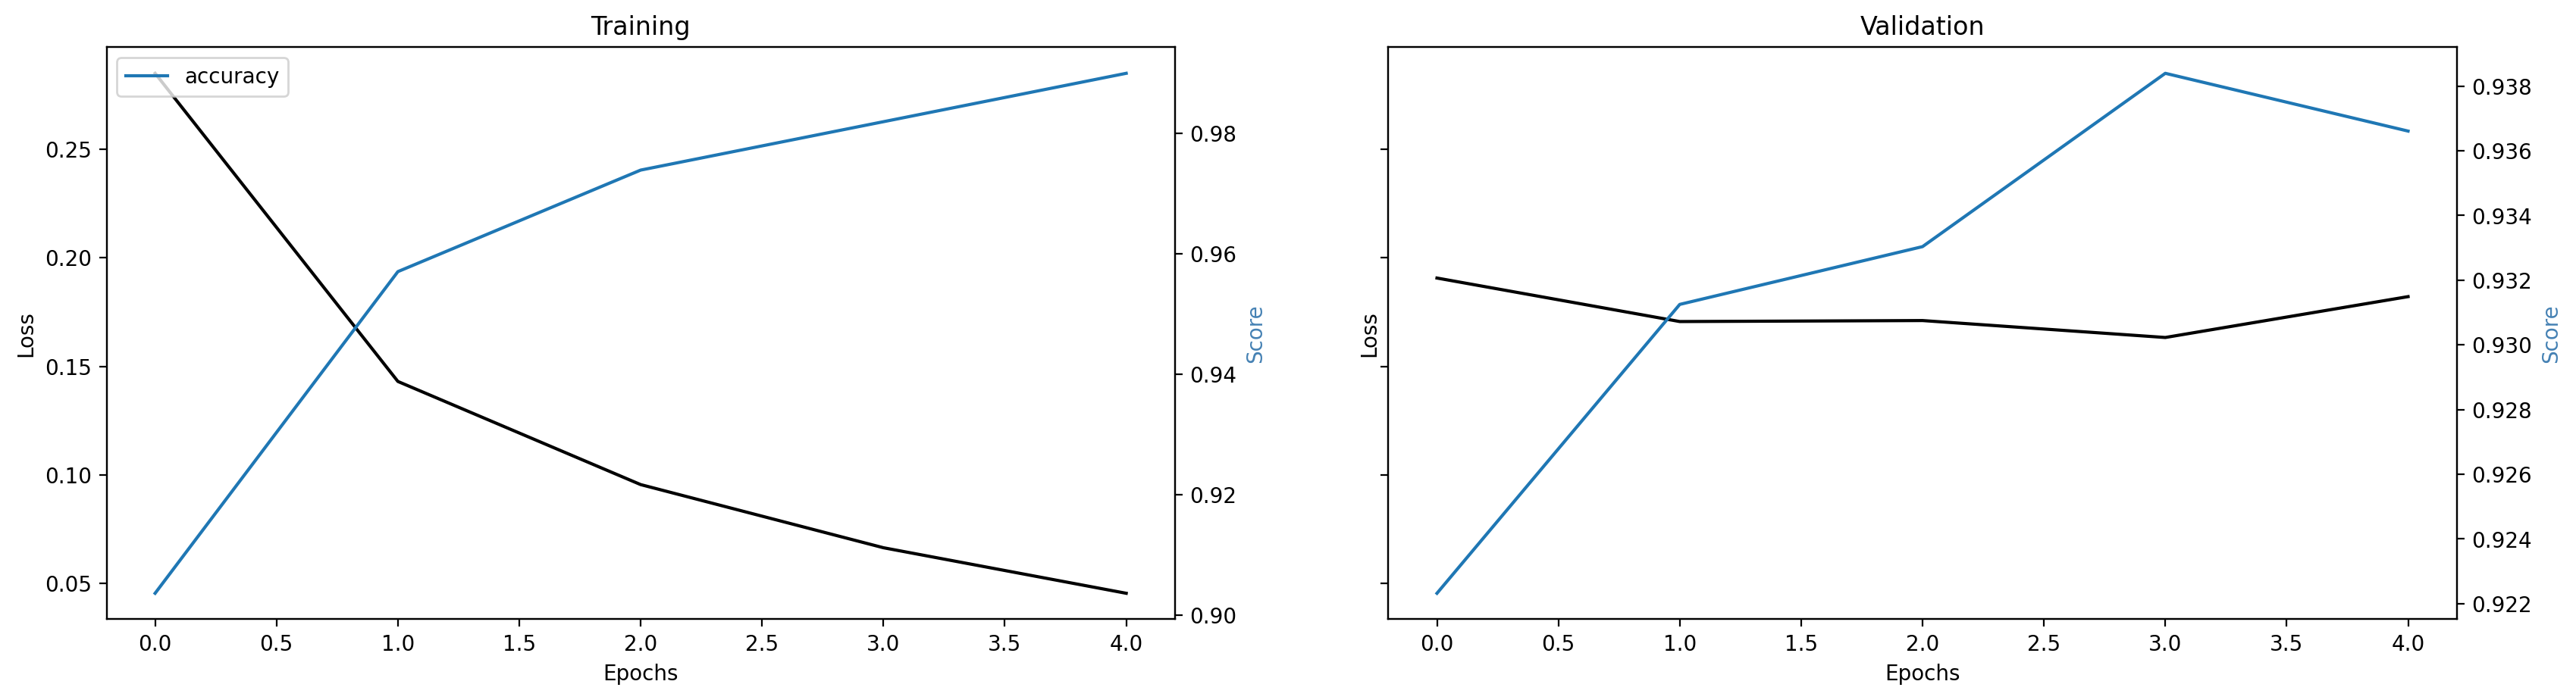

In [20]:
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True , figsize=(20,5) , dpi = 200)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [23]:
# model.save('LSTM.h5')

In [21]:
################### CONFUSION MATRIX #############
predicted = []
predicted_prob = model.predict(val_x)
for pred in predicted_prob:
    predicted.append(np.argmax(pred))

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

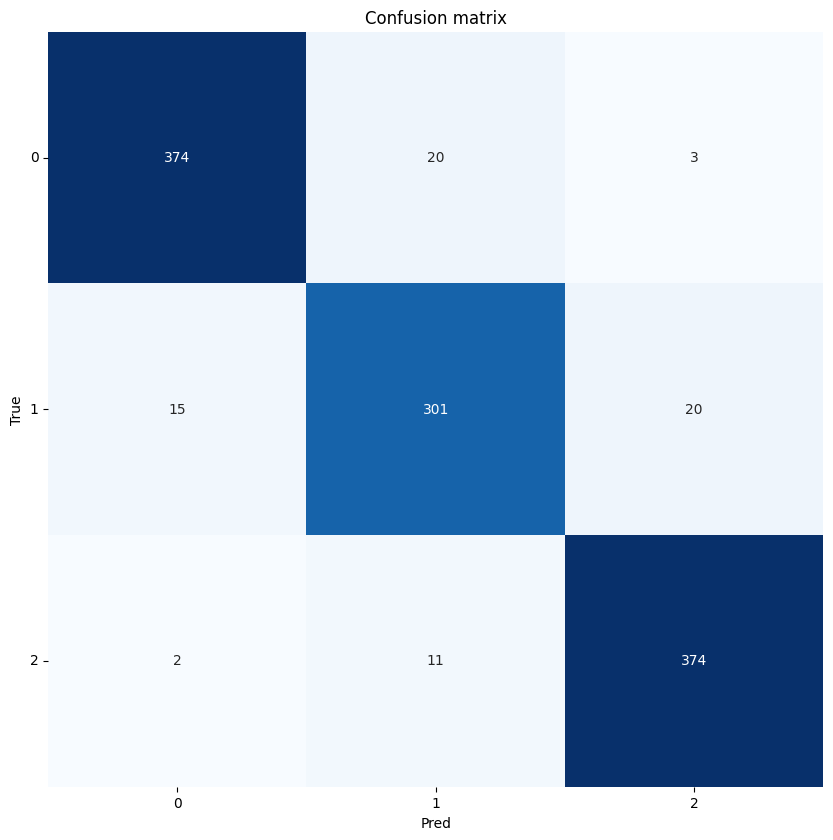

In [22]:
classes = np.unique(val_y)
cm = confusion_matrix(val_y, predicted)
fig, ax = plt.subplots(figsize=(10,10) , dpi = 100)
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels= classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)